In [7]:
import pandas as pd
data = pd.read_csv('/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662-Data-Mining-and-Visualization-Project/Fire_Incidents_Data.csv')

/var/folders/46/jmhrztm12j78w43g2fnymb340000gn/T/ipykernel_10657/1447026697.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662-Data-Mining-and-Visualization-Project/Fire_Incidents_Data.csv')


In [8]:
data

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
0,3627138,81 - Engine Area,NaN,NaN,0.0,0.0,15000.0,NaN,NaN,2018-02-24T21:12:00,...,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24T21:04:29,2018-02-24T21:10:11,0.0
1,3627139,"75 - Trash, rubbish area (outside)",NaN,NaN,0.0,0.0,50.0,NaN,NaN,2018-02-24T21:29:42,...,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24T21:24:43,2018-02-24T21:29:31,0.0
2,3627140,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T13:29:59,2018-02-25T13:36:49,0.0
3,3627141,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,NaN,2018-02-25T14:19:25,...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25T14:13:39,2018-02-25T14:18:07,0.0
4,3627142,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T18:20:43,2018-02-25T18:26:19,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32924,3660062,22 - Sleeping Area or Bedroom (inc. patients r...,01 - Normal (no change),1 - No business interruption,NaN,0.0,0.0,0.0,0.0,2023-01-01T07:29:02,...,98 - Not applicable: Alarm operated OR presenc...,4 - Interconnected,3 - No one (at risk) evacuated as a result of ...,3 - Spread to entire room of origin,4 - Other reason for non activation/operation,1 - Full sprinkler system present,1 - Fire extinguished prior to arrival,2023-01-01T07:21:18,2023-01-01T07:26:30,0.0
32925,3660063,64 - Porch or Balcony,01 - Normal (no change),8 - Not applicable (not a business),NaN,0.0,3000.0,0.0,0.0,2023-01-01T10:57:07,...,"5 - Separated from fire (e.g. wall, etc)",4 - Interconnected,7 - Not applicable: Occupant(s) first alerted ...,9 - Confined to roof/exterior structure,8 - Not applicable - no sprinkler system present,3 - No sprinkler system,4 - Flames showing from small area (one storey...,2023-01-01T10:48:10,2023-01-01T10:51:37,0.0
32926,3660064,24 - Cooking Area or Kitchen,01 - Normal (no change),8 - Not applicable (not a business),NaN,0.0,1000.0,0.0,0.0,2023-01-01T12:28:05,...,98 - Not applicable: Alarm operated OR presenc...,1 - Battery operated,2 - Some persons (at risk) self evacuated as a...,"4 - Spread beyond room of origin, same floor",8 - Not applicable - no sprinkler system present,3 - No sprinkler system,1 - Fire extinguished prior to arrival,2023-01-01T12:22:14,2023-01-01T12:27:04,0.0
32927,3660065,99 - Undetermined (formerly 98),NaN,NaN,NaN,0.0,5000.0,NaN,0.0,2023-01-01T13:17:38,...,NaN,NaN,NaN,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,2023-01-01T12:58:07,2023-01-01T13:04:24,0.0


# 1. Drop and combine some columns

In [9]:
#drop the columns 'id', 'Incident_Number' and 'Level_Of_Origin' since they're just identifiers
#drop 'Exposures' since it has too many missing values
#drop 'Number_of_responding_apparatus' bc it's almost perfectly collinear with 'Number_of_responding_personnel'
#drop 'Sprinkler_System_Presence' since we already have ''Sprinkler_System_Operation'
#drop 'Fire_Alarm_System_Operation' and 'Fire_Alarm_System_Presence'; only keep 'Fire_Alarm_System_Impact_on_Evacuation'
#drop 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type' and only keep 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation'
data_dropped = data.drop(columns=['_id', 'Incident_Number', 'Level_Of_Origin', 'Exposures', 'Number_of_responding_apparatus', 'Sprinkler_System_Presence', 'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type', ], errors='ignore')

#make sure these columns have int objects since the original dataset is having some data quality issues
int_columns = [
    'Incident_Station_Area',
    'Civilian_Casualties',
    'Count_of_Persons_Rescued',
    'Incident_Ward',
    'Number_of_responding_personnel',
    'TFS_Firefighter_Casualties',
    'Estimated_Number_Of_Persons_Displaced',
    'Estimated_Dollar_Loss'
]
for col in int_columns:
    data_dropped[col] = pd.to_numeric(data[col], errors='coerce').fillna(0).astype(int)

#combien 'TFS_Alarm_Time' and 'TFS_Arrival_Time' into one time metric, TFS_Response_Time', that represents the time difference in minutes between 'TFS_Arrival_Time' and TFS_Alarm_Time' for each record
timestamp_columns = ['TFS_Alarm_Time', 'TFS_Arrival_Time', 'Last_TFS_Unit_Clear_Time']
data_dropped[timestamp_columns] = data_dropped[timestamp_columns].apply(pd.to_datetime, errors='coerce')
data_dropped['TFS_Response_Time'] = ((data_dropped['TFS_Arrival_Time'] - data_dropped['TFS_Alarm_Time']).dt.total_seconds() / 60).round(2)
data_dropped = data_dropped.drop(columns=['TFS_Alarm_Time', 'TFS_Arrival_Time'])

#combine latitude and longitude into one distance metric
data_dropped['Geo_Coordinate'] = (data_dropped['Latitude']**2 + data_dropped['Longitude']**2)**0.5
data_dropped = data_dropped.drop(columns=['Latitude', 'Longitude'])

#HMMMMMM maybe drop 'Intersection' and 'Incident_Ward' since we already have 'Geo_Coordinate'
data_dropped = data_dropped.drop(columns=['Intersection', 'Incident_Ward'], errors='ignore')

#import the cleaned dataset as a csv file
# from IPython.display import FileLink
# data_dropped.to_csv('data_dropped.csv', index=False)  # index=False to avoid saving row indices
# FileLink('data_dropped.csv')

/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662-Data-Mining-and-Visualization-Project/data_dropped.csv

In [10]:
data_dropped.dtypes

Area_of_Origin                                                           object
Building_Status                                                          object
Business_Impact                                                          object
Civilian_Casualties                                                       int64
Count_of_Persons_Rescued                                                  int64
Estimated_Dollar_Loss                                                     int64
Estimated_Number_Of_Persons_Displaced                                     int64
Ext_agent_app_or_defer_time                                              object
Extent_Of_Fire                                                           object
Final_Incident_Type                                                      object
Fire_Alarm_System_Impact_on_Evacuation                                   object
Fire_Under_Control_Time                                                  object
Ignition_Source                         

# 2. We need to decide what to do with the missing values

## 2.1 Let's see if there's any pattern or relationship between all the missing values (not surprisingly, there is)

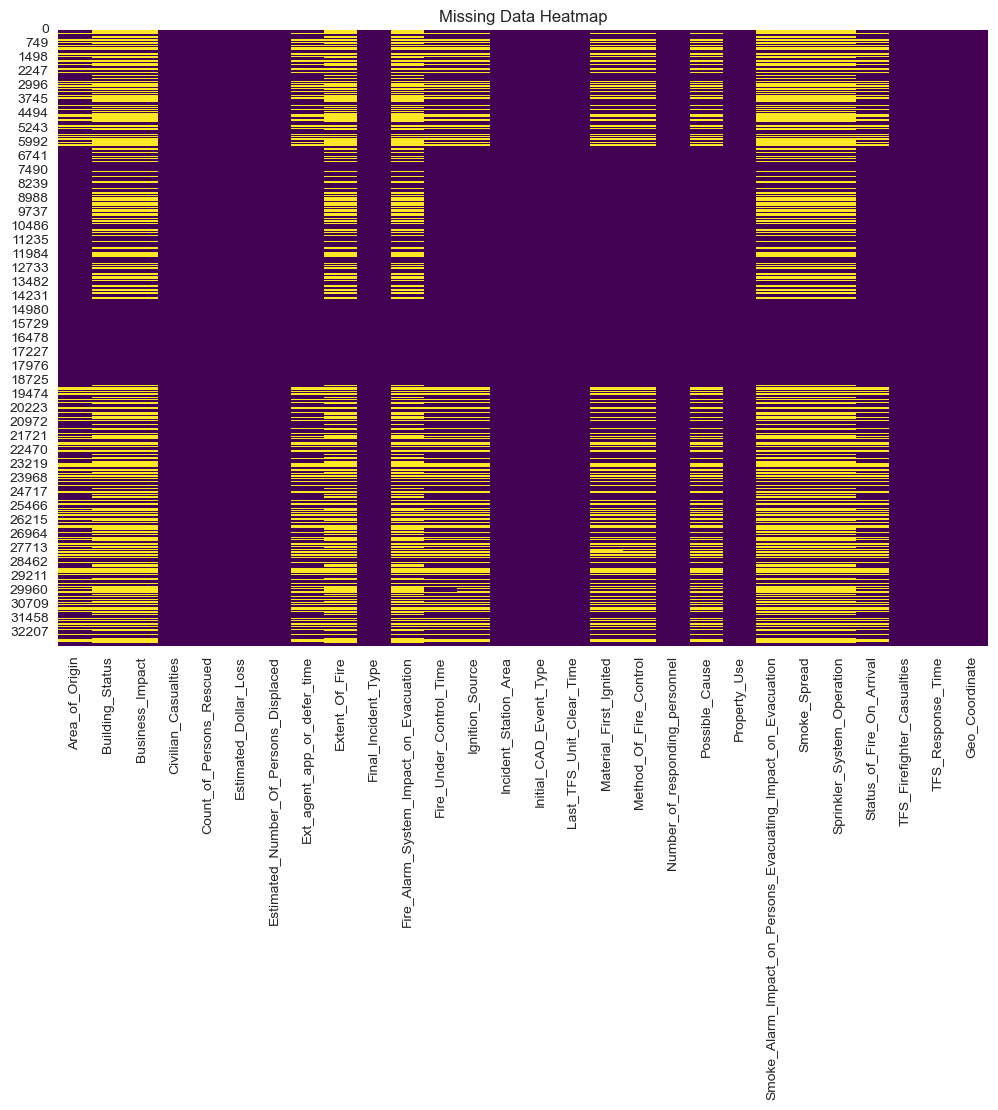

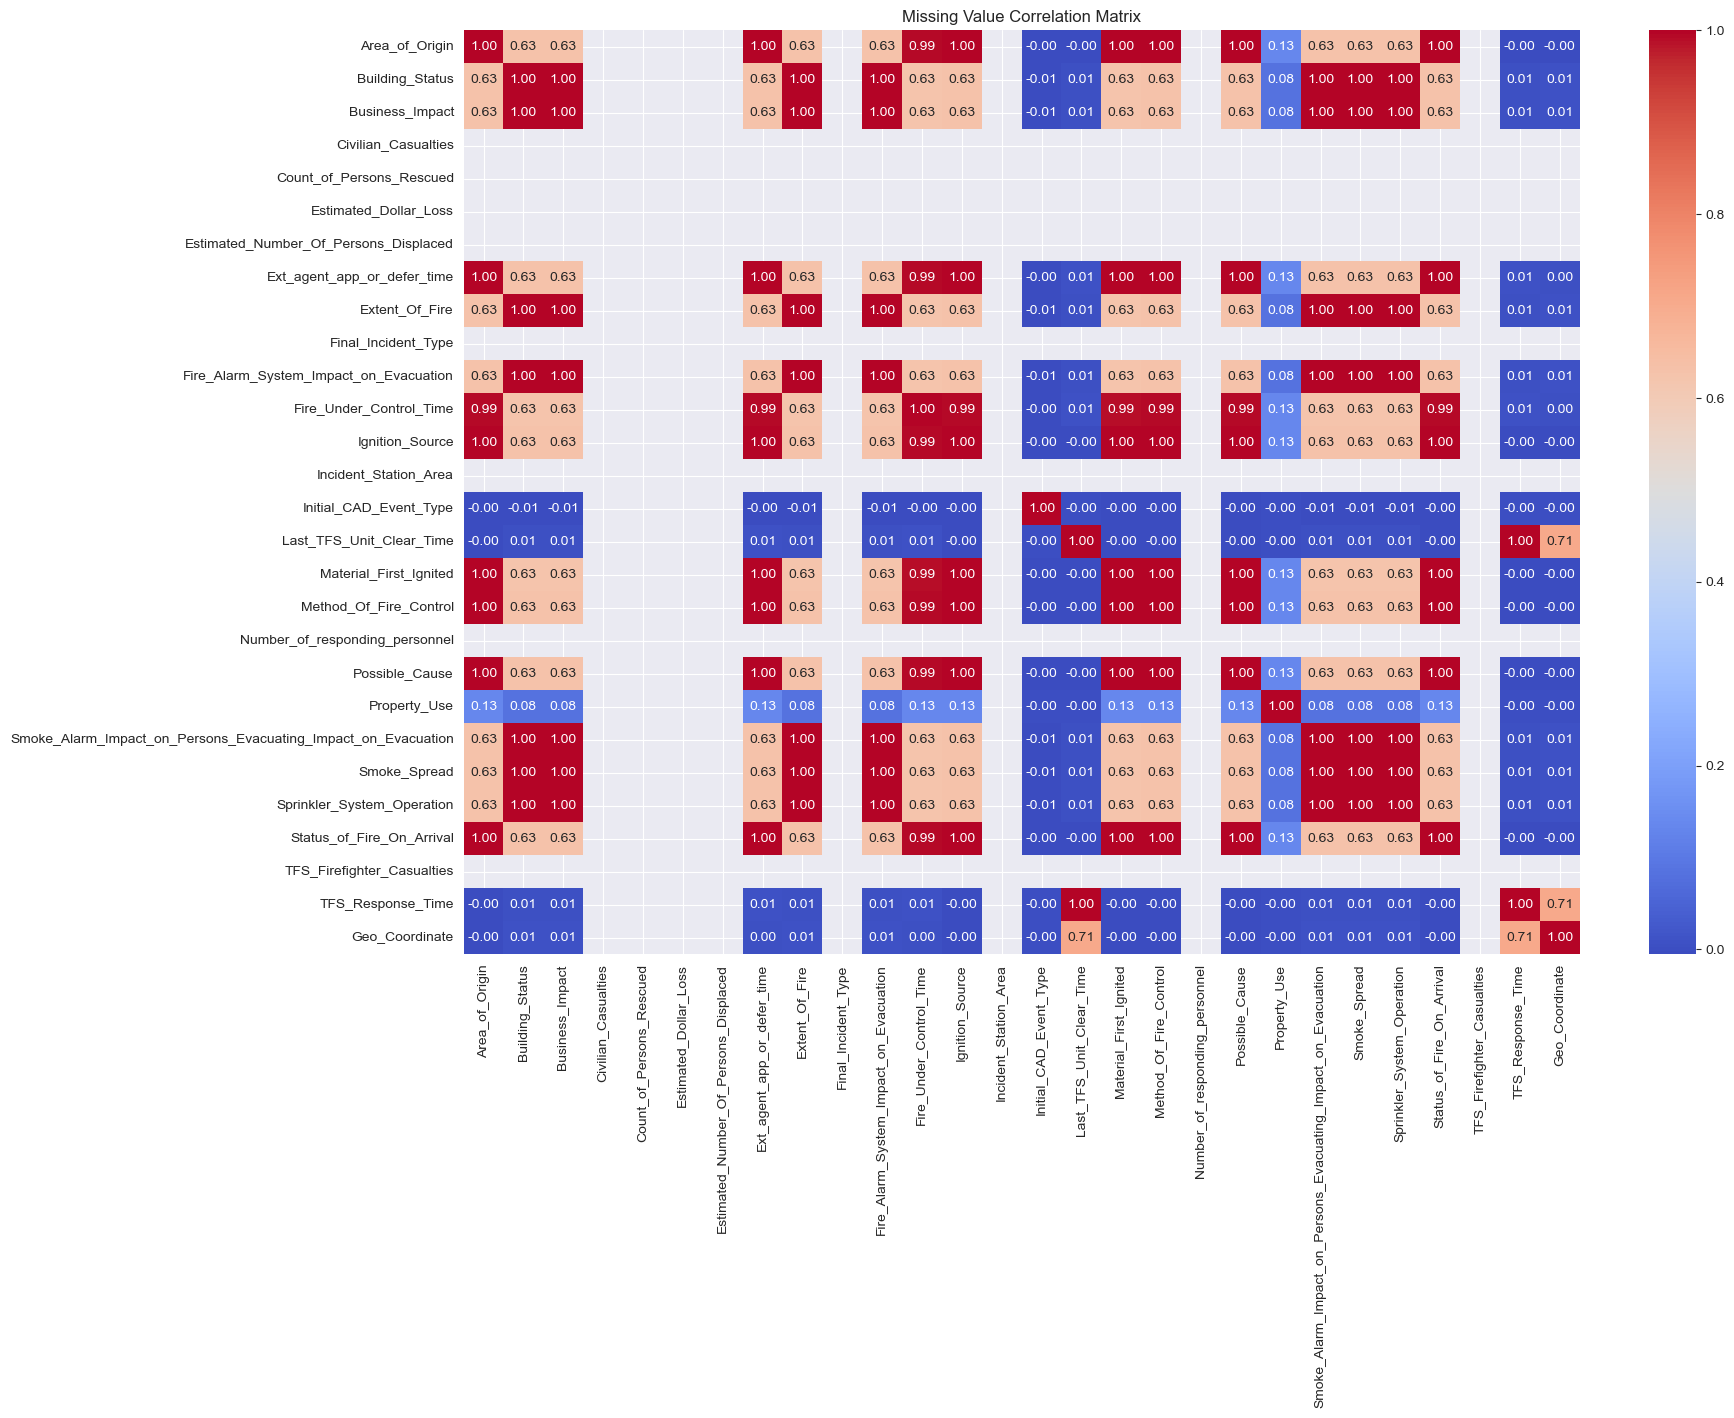

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#heatmap to visualize missing data
plt.figure(figsize=(12, 8))
sns.heatmap(data_dropped.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

#missingness correlation matrix
missing_corr = data_dropped.isnull().corr()
plt.figure(figsize=(18, 12))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Missing Value Correlation Matrix')
plt.show()

## 2.2 MICE Imputation
## Unfortunately, the code was taking way too long to run (3h+), so I had to try other imputation methods

In [12]:
# import pandas as pd
# from sklearn.impute import IterativeImputer
# from sklearn.preprocessing import OneHotEncoder
#
# # Separate numerical and categorical columns
# numerical_cols = data_dropped.select_dtypes(include=['float64', 'int64']).columns
# categorical_cols = data_dropped.select_dtypes(include=['object']).columns
#
# # One-hot encode categorical columns to convert them to a numerical format for MICE
# # This will create new columns for each category and allow MICE to impute across all features
# encoder = OneHotEncoder(drop='first', sparse_output=False)
# categorical_encoded = pd.DataFrame(encoder.fit_transform(data_dropped[categorical_cols]),
#                                    columns=encoder.get_feature_names_out(categorical_cols))
#
# # Combine numerical and encoded categorical data
# data_encoded = pd.concat([data_dropped[numerical_cols], categorical_encoded], axis=1)
#
# # Apply MICE imputation to the combined dataset
# mice_imputer = IterativeImputer(max_iter=10, random_state=0)
# data_imputed = pd.DataFrame(mice_imputer.fit_transform(data_encoded), columns=data_encoded.columns)
#
# # Ensure 'Estimated_Dollar_Loss' does not contain negative values if it exists
# if 'Estimated_Dollar_Loss' in data_imputed.columns:
#     data_imputed['Estimated_Dollar_Loss'] = data_imputed['Estimated_Dollar_Loss'].clip(lower=0)
#
# # Separate the imputed numerical and categorical data
# imputed_numerical_data = data_imputed[numerical_cols]
# imputed_categorical_encoded = data_imputed[categorical_encoded.columns]
#
# # Inverse transform the one-hot encoded categorical columns back to original categories
# imputed_categorical_data = pd.DataFrame(encoder.inverse_transform(imputed_categorical_encoded),
#                                         columns=categorical_cols)
#
# # Combine the imputed numerical and categorical data back into a single DataFrame in the original column order
# data_imputed = pd.concat([imputed_numerical_data, imputed_categorical_data], axis=1)[data_dropped.columns]
#
# data_imputed.head()

## 2.3 KNN Imputation (K=20)

In [17]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Separate datetime columns and save for later
datetime_columns = data_dropped.select_dtypes(include=['datetime64', 'object']).columns
non_datetime_data = data_dropped.drop(columns=datetime_columns)

# Encode categorical columns
non_datetime_encoded = non_datetime_data.copy()
for col in non_datetime_encoded.select_dtypes(include=['object']).columns:
    non_datetime_encoded[col] = non_datetime_encoded[col].astype('category').cat.codes.replace(-1, np.nan)

# Save columns with integer types
int_columns = non_datetime_encoded.select_dtypes(include=['int64']).columns

# Apply Min-Max scaling
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(non_datetime_encoded), columns=non_datetime_encoded.columns)

# Select columns with missing values
missing_cols = scaled_data.columns[scaled_data.isna().any()].tolist()

# Initialize and apply KNN Imputer on columns with missing values only
knn_imputer = KNNImputer(n_neighbors=20)
scaled_data[missing_cols] = knn_imputer.fit_transform(scaled_data[missing_cols])

# Inverse scaling to return data to original range
data_imputed = pd.DataFrame(scaler.inverse_transform(scaled_data), columns=scaled_data.columns)

# Round and convert integer columns back to int type
for col in int_columns:
    data_imputed[col] = data_imputed[col].round().astype('int64')

# Decode categorical columns back to original format
for col in data_dropped.select_dtypes(include=['object']).columns:
    if col in data_imputed.columns:
        data_imputed[col] = data_imputed[col].round().astype(int).replace(
            {code: category for code, category in enumerate(data_dropped[col].astype('category').cat.categories)}
        )

# Reattach datetime and original object columns
data_imputed = pd.concat([data_imputed, data_dropped[datetime_columns]], axis=1)

# Reorder columns to match original order
data_imputed = data_imputed[data_dropped.columns]

#there's one missing value left from the 'TFS_Response_Time' column that needs to be dropped
data_imputed = data_imputed.dropna()

data_imputed

/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662-Data-Mining-and-Visualization-Project/data_imputed.csv

In [ ]:
#import the cleaned dataset as a csv file
from IPython.display import FileLink
data_dropped.to_csv('data_imputed.csv', index=False)  # index=False to avoid saving row indices
FileLink('data_imputed.csv')